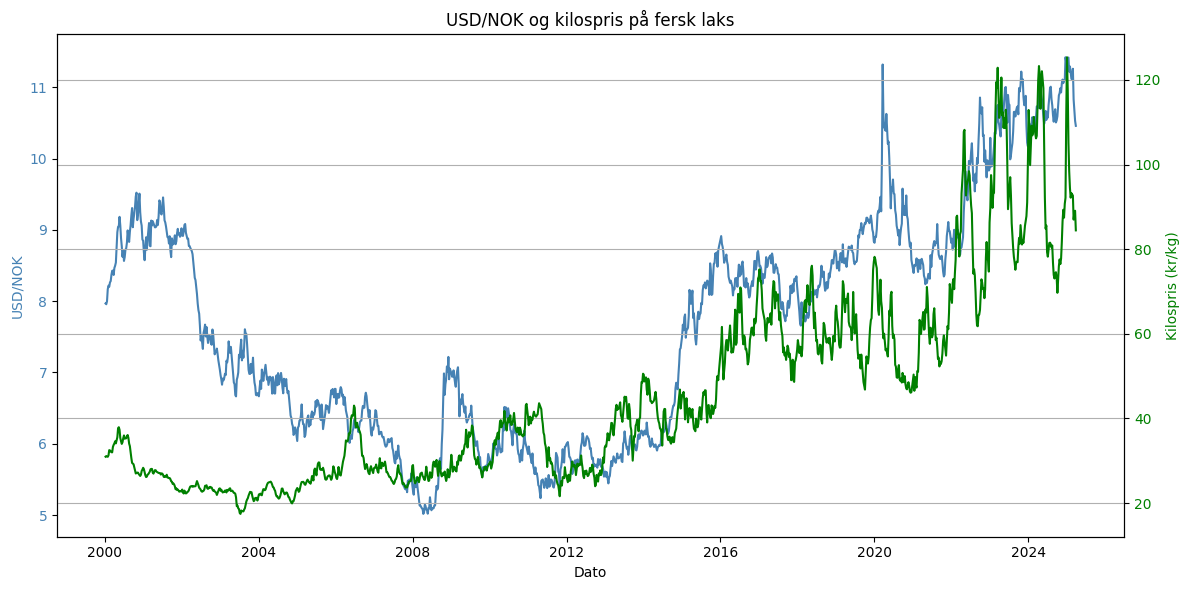

In [13]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------
# 1. HENT VALUTAKURS (USD/NOK)
# -------------------------------------
def hent_valutakurs():
    url = "https://data.norges-bank.no/api/data/EXR/B.USD.NOK.SP?format=sdmx-json&startPeriod=2000-01-01&endPeriod=2025-04-08"
    response = requests.get(url)
    data = response.json()

    dates = data['data']['structure']['dimensions']['observation'][0]['values']
    series_key = list(data['data']['dataSets'][0]['series'].keys())[0]
    observations = data['data']['dataSets'][0]['series'][series_key]['observations']

    records = [(dates[int(k)]['id'], v[0]) for k, v in observations.items()]
    df = pd.DataFrame(records, columns=["Dato", "USD/NOK"])
    df["Dato"] = pd.to_datetime(df["Dato"])
    df["USD/NOK"] = pd.to_numeric(df["USD/NOK"])
    df["Ukedag"] = df["Dato"].dt.weekday
    df = df[df["Ukedag"] == 4].copy()
    df["År"] = df["Dato"].dt.isocalendar().year
    df["Ukenr"] = df["Dato"].dt.isocalendar().week
    df["UkeID"] = df["År"].astype(str) + "-" + df["Ukenr"].astype(str).str.zfill(2)
    df = df[["UkeID", "Dato", "USD/NOK"]].sort_values("Dato").reset_index(drop=True)
    return df

# -------------------------------------
# 2. HENT EKSPORTDATA (SSB 03024)
# -------------------------------------
def hent_eksportdata():
    API_URL = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(API_URL, json=query)
    data = response.json()

    from itertools import product
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# -------------------------------------
# 3. ANALYSE – DOBBEL Y-AKSE
# -------------------------------------
def analyser():
    valutadata = hent_valutakurs()
    eksportdata = hent_eksportdata()
    samlet = pd.merge(valutadata, eksportdata, on="UkeID", how="inner")

    # Dobbel y-akse plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("Dato")
    ax1.set_ylabel("USD/NOK", color="steelblue")
    ax1.plot(samlet["Dato"], samlet["USD/NOK"], color="steelblue", label="USD/NOK")
    ax1.tick_params(axis='y', labelcolor='steelblue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Kilospris (kr/kg)", color="green")
    ax2.plot(samlet["Dato"], samlet["Fersk laks - Kilospris"], color="green", label="Kilospris")
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title("USD/NOK og kilospris på fersk laks")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------
# 4. KJØR
# -------------------------------------
if __name__ == "__main__":
    analyser()


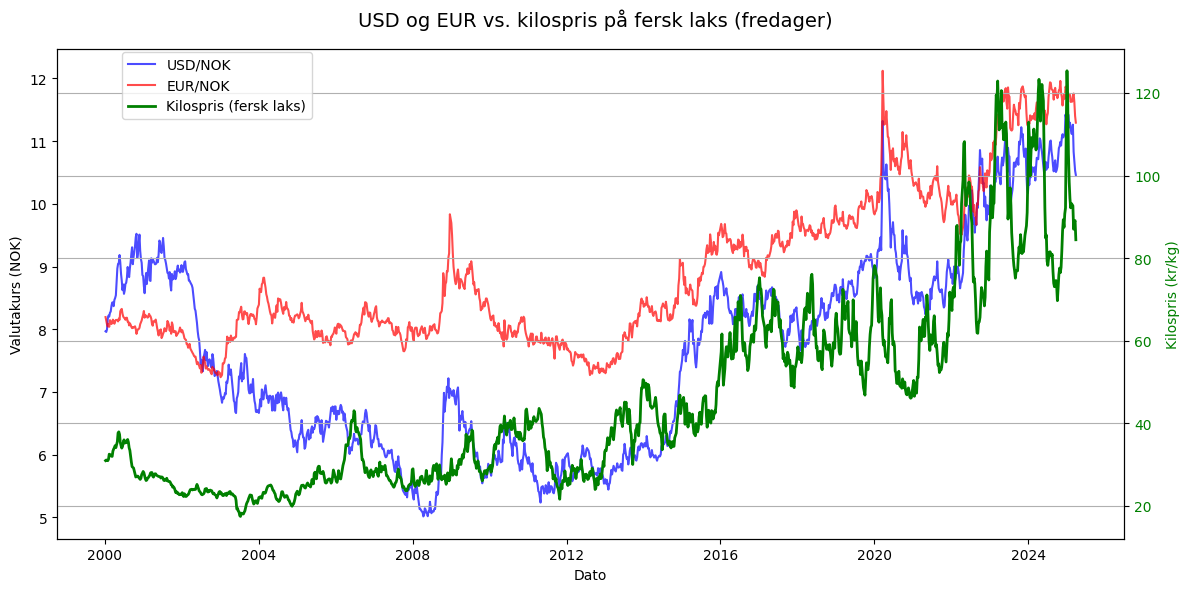

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Funksjon for å hente valutakurs (fredager)
def hent_valutakurs(par, navn):
    url = f"https://data.norges-bank.no/api/data/EXR/B.{par}.SP?format=sdmx-json&startPeriod=2000-01-01&endPeriod=2025-04-08"
    response = requests.get(url)
    data = response.json()

    dates = data['data']['structure']['dimensions']['observation'][0]['values']
    series_key = list(data['data']['dataSets'][0]['series'].keys())[0]
    observations = data['data']['dataSets'][0]['series'][series_key]['observations']
    records = [(dates[int(k)]['id'], v[0]) for k, v in observations.items()]
    df = pd.DataFrame(records, columns=["Dato", navn])
    df["Dato"] = pd.to_datetime(df["Dato"])
    df[navn] = pd.to_numeric(df[navn])
    df["Ukedag"] = df["Dato"].dt.weekday
    df = df[df["Ukedag"] == 4].copy()
    df["År"] = df["Dato"].dt.isocalendar().year
    df["Ukenr"] = df["Dato"].dt.isocalendar().week
    df["UkeID"] = df["År"].astype(str) + "-" + df["Ukenr"].astype(str).str.zfill(2)
    return df[["UkeID", "Dato", navn]]

# Funksjon for å hente eksportdata (fersk laks)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# Sammenligne begge valutakurser med kilospris
def analyser_valuta_vs_pris():
    df_usd = hent_valutakurs("USD.NOK", "USD/NOK")
    df_eur = hent_valutakurs("EUR.NOK", "EUR/NOK")
    df_pris = hent_eksportdata()

    # Slå sammen alt
    df = df_usd.merge(df_eur, on=["UkeID", "Dato"])
    df = df.merge(df_pris[["UkeID", "Fersk laks - Kilospris"]], on="UkeID")

    # Plot med dobbel y-akse (to valutakurser + pris)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Venstre y-akse: valutakurser
    ax1.plot(df["Dato"], df["USD/NOK"], label="USD/NOK", color="blue", alpha=0.7)
    ax1.plot(df["Dato"], df["EUR/NOK"], label="EUR/NOK", color="red", alpha=0.7)
    ax1.set_ylabel("Valutakurs (NOK)", color="black")
    ax1.tick_params(axis='y')

    # Høyre y-akse: kilospris
    ax2 = ax1.twinx()
    ax2.plot(df["Dato"], df["Fersk laks - Kilospris"], label="Kilospris (fersk laks)", color="green", linewidth=2)
    ax2.set_ylabel("Kilospris (kr/kg)", color="green")
    ax2.tick_params(axis='y', labelcolor='green')

    # Layout
    ax1.set_xlabel("Dato")
    fig.suptitle("USD og EUR vs. kilospris på fersk laks (fredager)", fontsize=14)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Kjør
if __name__ == "__main__":
    analyser_valuta_vs_pris()


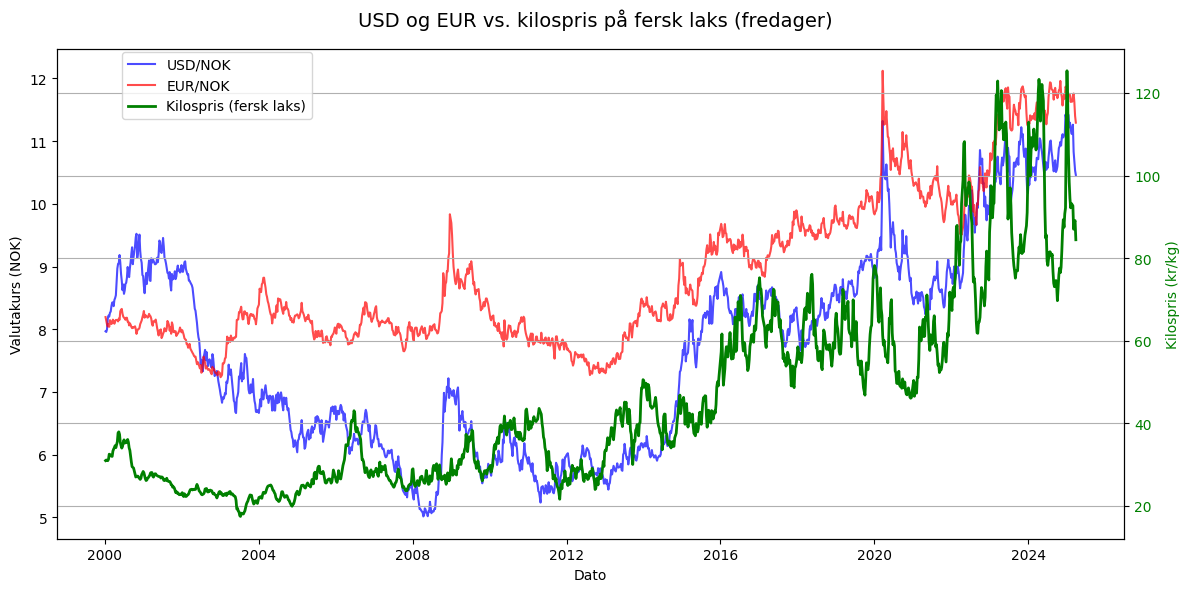


KORRELASJONER (fersk laks):
EUR/NOK og kilospris: 0.8662305493348187
USD/NOK og kilospris: 0.7347800018342859


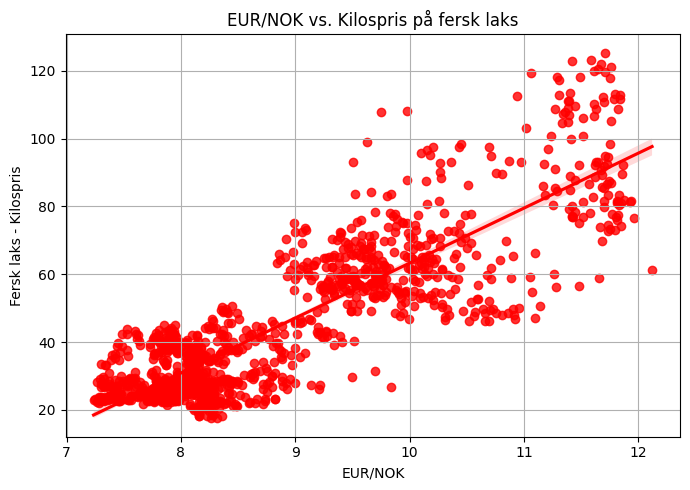

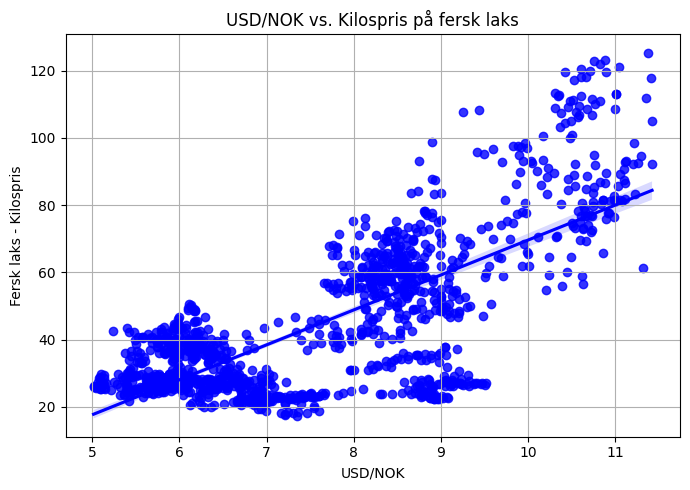

In [17]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hent valutakurs (fredager)
def hent_valutakurs(par, navn):
    url = f"https://data.norges-bank.no/api/data/EXR/B.{par}.SP?format=sdmx-json&startPeriod=2000-01-01&endPeriod=2025-04-08"
    response = requests.get(url)
    data = response.json()

    dates = data['data']['structure']['dimensions']['observation'][0]['values']
    series_key = list(data['data']['dataSets'][0]['series'].keys())[0]
    observations = data['data']['dataSets'][0]['series'][series_key]['observations']
    records = [(dates[int(k)]['id'], v[0]) for k, v in observations.items()]
    df = pd.DataFrame(records, columns=["Dato", navn])
    df["Dato"] = pd.to_datetime(df["Dato"])
    df[navn] = pd.to_numeric(df[navn])
    df["Ukedag"] = df["Dato"].dt.weekday
    df = df[df["Ukedag"] == 4].copy()
    df["År"] = df["Dato"].dt.isocalendar().year
    df["Ukenr"] = df["Dato"].dt.isocalendar().week
    df["UkeID"] = df["År"].astype(str) + "-" + df["Ukenr"].astype(str).str.zfill(2)
    return df[["UkeID", "Dato", navn]]

# 2. Hent eksportdata (SSB tabell 03024)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# 3. Hovedanalyse
def analyser_valuta_vs_pris():
    df_usd = hent_valutakurs("USD.NOK", "USD/NOK")
    df_eur = hent_valutakurs("EUR.NOK", "EUR/NOK")
    df_pris = hent_eksportdata()

    # Slå sammen alle datasett på ukeID og dato
    df = df_usd.merge(df_eur, on=["UkeID", "Dato"])
    df = df.merge(df_pris[["UkeID", "Fersk laks - Kilospris"]], on="UkeID")

    # ---------- 1: Plot alle i én graf ----------
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("Dato")
    ax1.set_ylabel("Valutakurs (NOK)")
    ax1.plot(df["Dato"], df["USD/NOK"], label="USD/NOK", color="blue", alpha=0.7)
    ax1.plot(df["Dato"], df["EUR/NOK"], label="EUR/NOK", color="red", alpha=0.7)
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Kilospris (kr/kg)", color="green")
    ax2.plot(df["Dato"], df["Fersk laks - Kilospris"], label="Kilospris (fersk laks)", color="green", linewidth=2)
    ax2.tick_params(axis='y', labelcolor='green')

    fig.suptitle("USD og EUR vs. kilospris på fersk laks (fredager)", fontsize=14)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- 2: Korrelasjoner ----------
    print("\nKORRELASJONER (fersk laks):")
    print("EUR/NOK og kilospris:", df["EUR/NOK"].corr(df["Fersk laks - Kilospris"]))
    print("USD/NOK og kilospris:", df["USD/NOK"].corr(df["Fersk laks - Kilospris"]))

    # ---------- 3: Scatterplots ----------
    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="EUR/NOK", y="Fersk laks - Kilospris", color="red")
    plt.title("EUR/NOK vs. Kilospris på fersk laks")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="USD/NOK", y="Fersk laks - Kilospris", color="blue")
    plt.title("USD/NOK vs. Kilospris på fersk laks")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Kjør
if __name__ == "__main__":
    analyser_valuta_vs_pris()


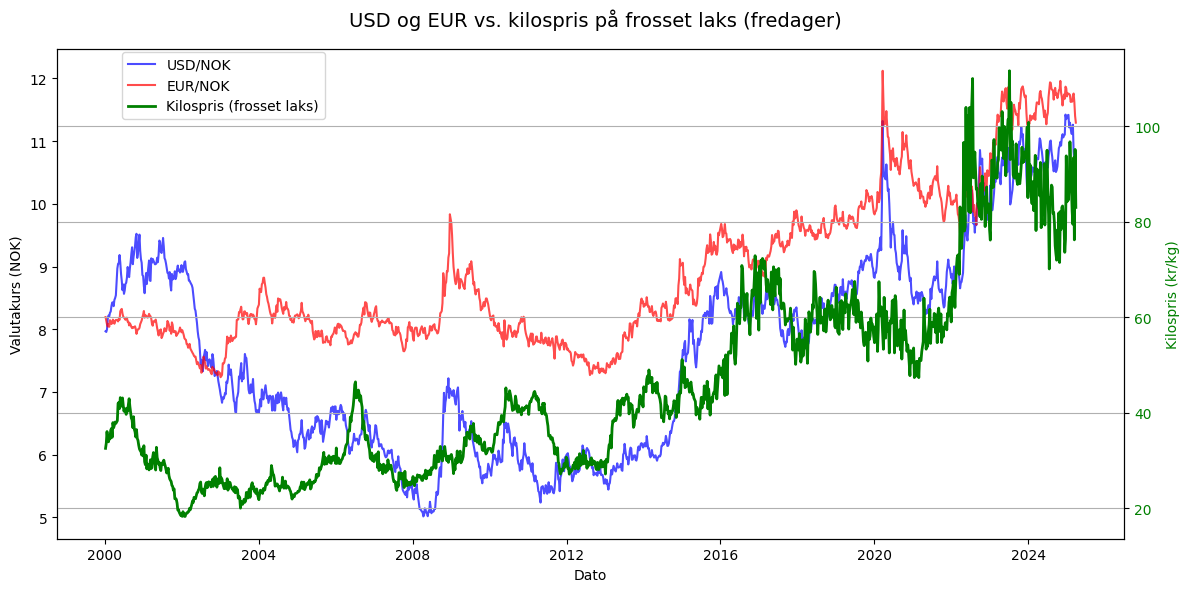


KORRELASJONER (frosset laks):
EUR/NOK og kilospris: 0.8690595957584969
USD/NOK og kilospris: 0.7439607146032466


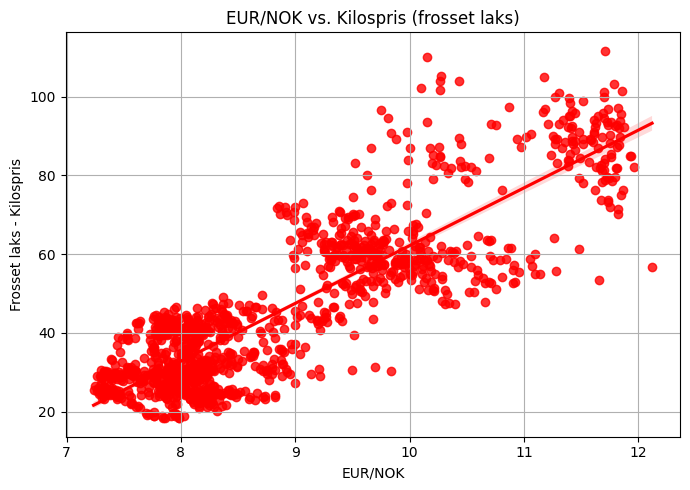

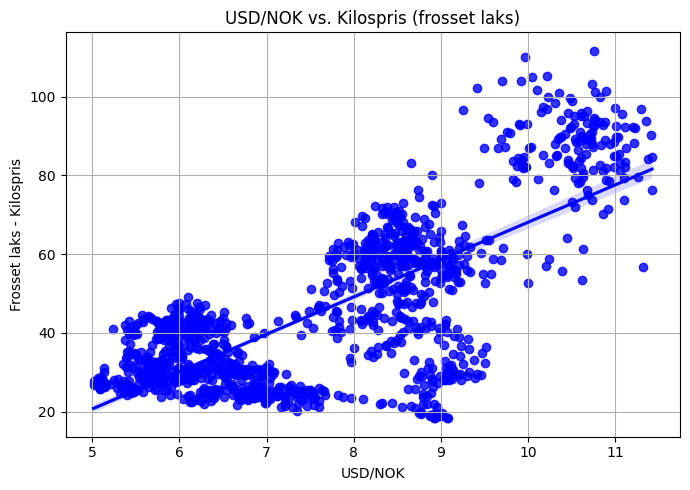

In [18]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hent valutakurs (kun fredager)
def hent_valutakurs(par, navn):
    url = f"https://data.norges-bank.no/api/data/EXR/B.{par}.SP?format=sdmx-json&startPeriod=2000-01-01&endPeriod=2025-04-08"
    response = requests.get(url)
    data = response.json()

    dates = data['data']['structure']['dimensions']['observation'][0]['values']
    series_key = list(data['data']['dataSets'][0]['series'].keys())[0]
    observations = data['data']['dataSets'][0]['series'][series_key]['observations']
    records = [(dates[int(k)]['id'], v[0]) for k, v in observations.items()]
    df = pd.DataFrame(records, columns=["Dato", navn])
    df["Dato"] = pd.to_datetime(df["Dato"])
    df[navn] = pd.to_numeric(df[navn])
    df["Ukedag"] = df["Dato"].dt.weekday
    df = df[df["Ukedag"] == 4].copy()
    df["År"] = df["Dato"].dt.isocalendar().year
    df["Ukenr"] = df["Dato"].dt.isocalendar().week
    df["UkeID"] = df["År"].astype(str) + "-" + df["Ukenr"].astype(str).str.zfill(2)
    return df[["UkeID", "Dato", navn]]

# 2. Hent eksportdata (SSB tabell 03024)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# 3. Analyse – for frosset laks
def analyser_frosset_laks():
    df_usd = hent_valutakurs("USD.NOK", "USD/NOK")
    df_eur = hent_valutakurs("EUR.NOK", "EUR/NOK")
    df_pris = hent_eksportdata()

    # Sammenstilling
    df = df_usd.merge(df_eur, on=["UkeID", "Dato"])
    df = df.merge(df_pris[["UkeID", "Frosset laks - Kilospris"]], on="UkeID")
    df = df.dropna()

    # ---------- 1: Plot ----------
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df["Dato"], df["USD/NOK"], label="USD/NOK", color="blue", alpha=0.7)
    ax1.plot(df["Dato"], df["EUR/NOK"], label="EUR/NOK", color="red", alpha=0.7)
    ax1.set_ylabel("Valutakurs (NOK)")
    ax1.set_xlabel("Dato")

    ax2 = ax1.twinx()
    ax2.plot(df["Dato"], df["Frosset laks - Kilospris"], label="Kilospris (frosset laks)", color="green", linewidth=2)
    ax2.set_ylabel("Kilospris (kr/kg)", color="green")
    ax2.tick_params(axis='y', labelcolor='green')

    fig.suptitle("USD og EUR vs. kilospris på frosset laks (fredager)", fontsize=14)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- 2: Korrelasjoner ----------
    print("\nKORRELASJONER (frosset laks):")
    print("EUR/NOK og kilospris:", df["EUR/NOK"].corr(df["Frosset laks - Kilospris"]))
    print("USD/NOK og kilospris:", df["USD/NOK"].corr(df["Frosset laks - Kilospris"]))

    # ---------- 3: Scatterplots ----------
    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="EUR/NOK", y="Frosset laks - Kilospris", color="red")
    plt.title("EUR/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    sns.regplot(data=df, x="USD/NOK", y="Frosset laks - Kilospris", color="blue")
    plt.title("USD/NOK vs. Kilospris (frosset laks)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Kjør
if __name__ == "__main__":
    analyser_frosset_laks()


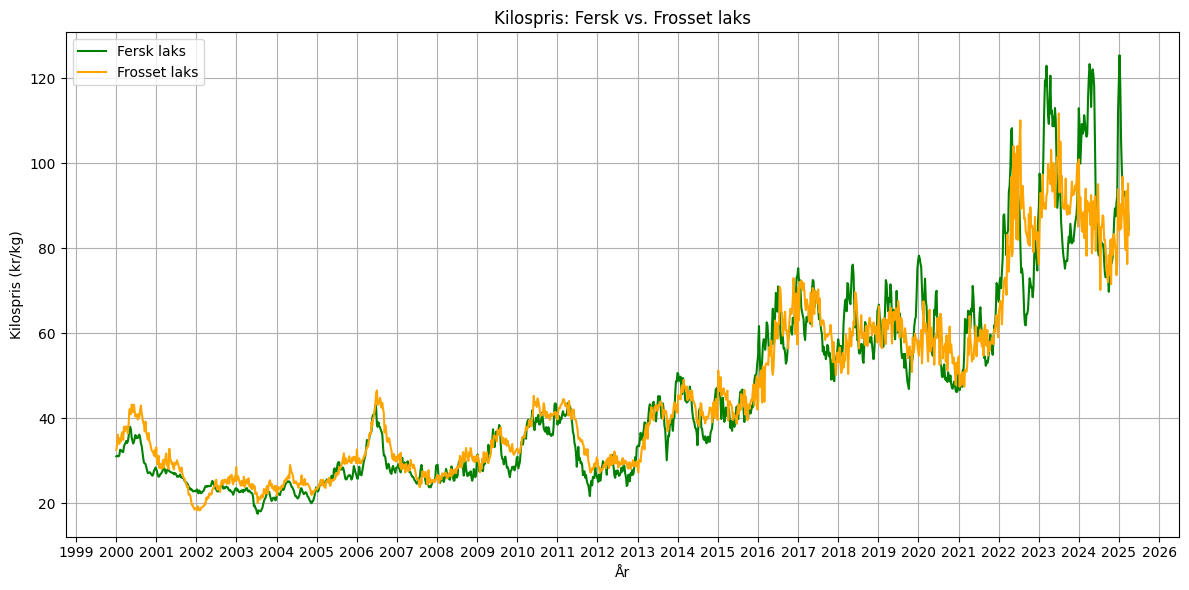

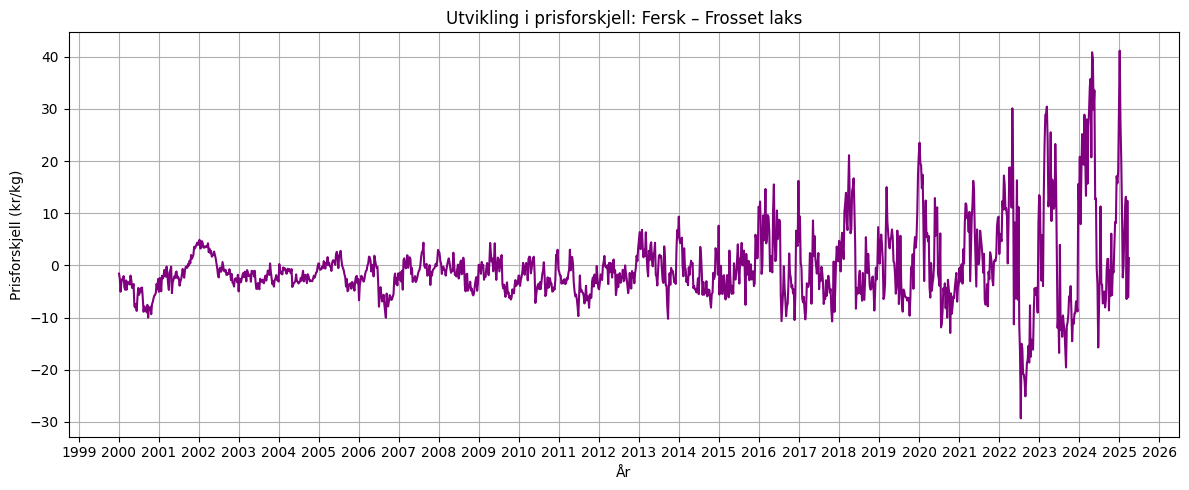


Statistikk for prisforskjell (Fersk og Frosset laks):
Gjennomsnitt:    -0.43 kr/kg
Median:          -1.63 kr/kg
Standardavvik:   7.17 kr/kg
Største forskjell: 41.17 kr/kg
Minste forskjell: -29.30 kr/kg

Prisforskjell per år (kr/kg):
      Gjennomsnitt  Median  Std.avvik
År                                   
2000         -5.40   -5.07       2.28
2001         -0.97   -1.46       2.42
2002          0.33   -0.44       2.68
2003         -2.41   -2.46       1.04
2004         -1.95   -1.94       1.10
2005         -0.92   -0.50       2.10
2006         -3.39   -3.02       3.09
2007         -0.58   -0.55       1.85
2008         -1.59   -1.53       2.15
2009         -1.84   -1.90       2.78
2010         -2.06   -2.27       2.43
2011         -3.69   -3.46       2.60
2012         -1.63   -1.46       1.95
2013          0.60    1.25       3.87
2014         -1.72   -2.14       3.63
2015         -1.16   -1.48       3.62
2016          2.04    1.81       7.14
2017         -2.41   -3.04       4.60
2018  

In [34]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Hent eksportdata fra SSB (tabell 03024)
def hent_eksportdata():
    url = "https://data.ssb.no/api/v0/no/table/03024/"
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    r = requests.post(url, json=query)
    data = r.json()

    from itertools import product
    dims = list(data["dimension"].keys())
    values = data["value"]
    dim_vals = [list(data["dimension"][d]["category"]["label"].values()) for d in dims]
    combos = list(product(*dim_vals))
    df = pd.DataFrame(combos, columns=dims)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)",
                        "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    df_pivot["UkeID"] = df_pivot["År og ukenr."].str.replace("U", "-")
    return df_pivot

# 2. Sammenligning og utvikling i prisforskjell
def analyser_fersk_vs_frosset():
    df = hent_eksportdata()
    df = df.dropna()

    # Konverter ukeID til mandagsdato i hver uke
    df["UkeDato"] = pd.to_datetime(df["UkeID"] + "-1", format="%Y-%W-%w")

    # Kalkuler prisforskjell
    df["Prisforskjell"] = df["Fersk laks - Kilospris"] - df["Frosset laks - Kilospris"]

    # ----------- 1. Plot: Sammenligning -----------
    plt.figure(figsize=(12, 6))
    plt.plot(df["UkeDato"], df["Fersk laks - Kilospris"], label="Fersk laks", color="green")
    plt.plot(df["UkeDato"], df["Frosset laks - Kilospris"], label="Frosset laks", color="orange")
    plt.xlabel("År")
    plt.ylabel("Kilospris (kr/kg)")
    plt.title("Kilospris: Fersk vs. Frosset laks")
    plt.legend()
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.show()

    # ----------- 2. Plot: Prisforskjell -----------
    plt.figure(figsize=(12, 5))
    plt.plot(df["UkeDato"], df["Prisforskjell"], color="purple")
    plt.xlabel("År")
    plt.ylabel("Prisforskjell (kr/kg)")
    plt.title("Utvikling i prisforskjell: Fersk – Frosset laks")
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.show()

    # ----------- 3. Statistikk -----------
    gjennomsnitt = df["Prisforskjell"].mean()
    median = df["Prisforskjell"].median()
    stdavvik = df["Prisforskjell"].std()
    maks = df["Prisforskjell"].max()
    min_ = df["Prisforskjell"].min()

    print("\nStatistikk for prisforskjell (Fersk og Frosset laks):")
    print(f"Gjennomsnitt:    {gjennomsnitt:.2f} kr/kg")
    print(f"Median:          {median:.2f} kr/kg")
    print(f"Standardavvik:   {stdavvik:.2f} kr/kg")
    print(f"Største forskjell: {maks:.2f} kr/kg")
    print(f"Minste forskjell: {min_:.2f} kr/kg")

    # ----------- 4. Statistikk per år -----------
    df["År"] = df["UkeDato"].dt.year

    stats_per_år = df.groupby("År")["Prisforskjell"].agg(["mean", "median", "std"]).round(2)
    print("\nPrisforskjell per år (kr/kg):")
    print(stats_per_år.rename(columns={"mean": "Gjennomsnitt", "median": "Median", "std": "Std.avvik"}))

    # ----------- 5. Statistikk per sesong (valgfritt) -----------
    def finn_sesong(row):
        måned = row.month
        if måned in [3, 4, 5]:
            return "Vår"
        elif måned in [6, 7, 8]:
            return "Sommer"
        elif måned in [9, 10, 11]:
            return "Høst"
        else:
            return "Vinter"

    df["Sesong"] = df["UkeDato"].apply(finn_sesong)

    stats_per_sesong = df.groupby("Sesong")["Prisforskjell"].agg(["mean", "median", "std"]).round(2)
    print("\nPrisforskjell per sesong (kr/kg):")
    print(stats_per_sesong.rename(columns={"mean": "Gjennomsnitt", "median": "Median", "std": "Std.avvik"}))


# 3. Kjør
if __name__ == "__main__":
    analyser_fersk_vs_frosset()
